# Ouly TOURE  
## Projet M2BI 2025 – Analyse du centre d’appel VANAD

Ce notebook présente :

- des **visualisations** et **analyses statistiques**,

Les jours ouvrables considérés sont **du lundi au vendredi**, et les heures de fonctionnement sont **de 08h00 à 20h00**.

In [1]:
# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

sns.set(style="whitegrid")  

In [2]:
# 2. Chargement des fichiers CSV

# chemin des fichiers
chemin_base = r"C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\VANAD_data"

# Recherche des fichiers d'appels et d'activités
fichiers_appels = sorted(glob.glob(f"{chemin_base}\\calls-2014-*.csv"))
fichiers_activites = sorted(glob.glob(f"{chemin_base}\\activity-2014-*.csv"))

# Affichage de contrôle
print(f"{len(fichiers_appels)} fichiers d'appels trouvés.")
print(f"{len(fichiers_activites)} fichiers d'activités trouvés.")

# Concaténation des appels (de janvier à décembre 2014)
donnees_appels = pd.concat([pd.read_csv(f) for f in fichiers_appels], ignore_index=True)

# Concaténation des activités des agents (de janvier à décembre 2014)
donnees_activites = pd.concat([pd.read_csv(f) for f in fichiers_activites], ignore_index=True)

12 fichiers d'appels trouvés.
12 fichiers d'activités trouvés.


In [ ]:
# 3. Nettoyage des données d’appels
def nettoyage_et_conversion_appels(df):
    # Afficher les colonnes initiales pour vérification
    print("Colonnes avant nettoyage:", df.columns.tolist())
    
    # Normaliser noms de colonnes : strip, lowercase, underscore
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Conversion forcée des colonnes datetime, en coerce pour gérer erreurs
    for col in ['date_received', 'answered', 'hangup']:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Supprimer les lignes où une des dates critiques est manquante (NaT)
    df.dropna(subset=['date_received', 'answered', 'hangup'], inplace=True)
    
    # Calcul des temps d'attente (waiting_time) et de service (service_time) en secondes
    df['waiting_time'] = (df['answered'] - df['date_received']).dt.total_seconds()
    df['service_time'] = (df['hangup'] - df['answered']).dt.total_seconds()
    
    # Supprimer les lignes où waiting_time ou service_time est négatif (anomalies)
    df = df[(df['waiting_time'] >= 0) & (df['service_time'] >= 0)]
    
    # Extraction des composantes temporelles depuis date_received
    df['year'] = df['date_received'].dt.year
    df['month'] = df['date_received'].dt.month
    df['day'] = df['date_received'].dt.day
    df['day_of_week'] = df['date_received'].dt.dayofweek
    df['hour'] = df['date_received'].dt.hour
    df['minute'] = df['date_received'].dt.minute
    df['second'] = df['date_received'].dt.second
    df['time_of_day'] = df['hour'] + df['minute']/60 + df['second']/3600
    
    # Filtrer pour ne garder que les appels en jours ouvrables (lun-ven) et heures 08h-20h
    df = df[(df['day_of_week'] < 5) & (df['hour'] >= 8) & (df['hour'] <= 20)]
    
    # Tri chronologique
    df = df.sort_values(by='date_received').reset_index(drop=True)
    
    # Affichage post nettoyage pour contrôle
    print(f"Nombre de lignes après nettoyage : {len(df)}")
    print(f"Colonnes après nettoyage : {df.columns.tolist()}")
    
    return df

# Application du nettoyage à mes données appels
donnees_appels = nettoyage_et_conversion_appels(donnees_appels)

Colonnes avant nettoyage: ['date_received', 'queue_name', 'agent_number', 'answered', 'consult', 'transfer', 'hangup']
Nombre de lignes après nettoyage : 1442772
Colonnes après nettoyage : ['date_received', 'queue_name', 'agent_number', 'answered', 'consult', 'transfer', 'hangup', 'waiting_time', 'service_time', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute', 'second', 'time_of_day']


In [ ]:
# 4. Nettoyage des données d’activités
def nettoyage_et_conversion_activites(df):
    print("Colonnes avant nettoyage:", df.columns.tolist())
    
    # Normaliser noms de colonnes
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    print("Colonnes après normalisation:", df.columns.tolist())
        
    
    # Conversion forcée des colonnes datetime
    for col in ['startdatetime', 'enddatetime']:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Supprimer les lignes avec datetime manquantes
    df.dropna(subset=['startdatetime', 'enddatetime'], inplace=True)
    
    # Calcul de la durée en secondes
    df['duration'] = (df['enddatetime'] - df['startdatetime']).dt.total_seconds()
    
    # Supprimer les durées négatives ou nulles
    df = df[df['duration'] > 0]
    
    # Extraire des variables temporelles depuis startdatetime
    df['year'] = df['startdatetime'].dt.year
    df['month'] = df['startdatetime'].dt.month
    df['day'] = df['startdatetime'].dt.day
    df['day_of_week'] = df['startdatetime'].dt.dayofweek
    df['hour'] = df['startdatetime'].dt.hour
    df['minute'] = df['startdatetime'].dt.minute
    df['second'] = df['startdatetime'].dt.second
    df['time_of_day'] = df['hour'] + df['minute']/60 + df['second']/3600
    
    # Filtrer sur jours ouvrables et heures 08h-20h 
    df = df[(df['day_of_week'] < 5) & (df['hour'] >= 8) & (df['hour'] <= 20)]
    
    # Trier chronologiquement
    df = df.sort_values(by='startdatetime').reset_index(drop=True)
    
    print(f"Nombre de lignes après nettoyage : {len(df)}")
    print(f"Colonnes après nettoyage : {df.columns.tolist()}")
    
    return df

# Application du nettoyage à mes données activities
donnees_activites = nettoyage_et_conversion_activites(donnees_activites)



Colonnes avant nettoyage: ['id', 'user_id', 'dnd_id', 'campaign_id', 'extension', 'last_call_id', 'startdatetime', 'enddatetime', 'agent_id', 'duration', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute', 'second', 'time_of_day']
Colonnes après normalisation: ['id', 'user_id', 'dnd_id', 'campaign_id', 'extension', 'last_call_id', 'startdatetime', 'enddatetime', 'agent_id', 'duration', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute', 'second', 'time_of_day']
Nombre de lignes après nettoyage : 1509997
Colonnes après nettoyage : ['id', 'user_id', 'dnd_id', 'campaign_id', 'extension', 'last_call_id', 'startdatetime', 'enddatetime', 'agent_id', 'duration', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute', 'second', 'time_of_day']


In [6]:
# Afficher les 5 premières lignes des données appels nettoyées
print("Appels - Aperçu des données :")
print(donnees_appels.head())

# Afficher les 5 premières lignes des données activités nettoyées
print("\nActivités - Aperçu des données :")
print(donnees_activites.head())

Appels - Aperçu des données :
        date_received  queue_name  agent_number            answered consult  \
0 2014-01-02 08:03:21       30175        6935.0 2014-01-02 08:03:22     NaN   
1 2014-01-02 08:04:37       30560        6940.0 2014-01-02 08:04:38     NaN   
2 2014-01-02 08:06:26       30172        6968.0 2014-01-02 08:06:27     NaN   
3 2014-01-02 08:08:07       30175        9424.0 2014-01-02 08:08:08     NaN   
4 2014-01-02 08:08:26       30172        8076.0 2014-01-02 08:08:27     NaN   

  transfer              hangup  waiting_time  service_time  year  month  day  \
0      NaN 2014-01-02 08:05:54           1.0         152.0  2014      1    2   
1      NaN 2014-01-02 08:09:49           1.0         311.0  2014      1    2   
2      NaN 2014-01-02 08:15:17           1.0         530.0  2014      1    2   
3      NaN 2014-01-02 08:10:37           1.0         149.0  2014      1    2   
4      NaN 2014-01-02 08:14:59           1.0         392.0  2014      1    2   

   day_of_week

In [7]:
# Dossier de sauvegarde existant
chemin_projet = r"C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\SimulationCentreAppelsVANAD\Data_csv"

# Chemins complets des fichiers à enregistrer
chemin_appels = os.path.join(chemin_projet, "donnees_appels_2014_nettoyees.csv")
chemin_activites = os.path.join(chemin_projet, "donnees_activites_2014_nettoyees.csv")

# Sauvegarde des fichiers CSV nettoyés
donnees_appels.to_csv(chemin_appels, index=False)
donnees_activites.to_csv(chemin_activites, index=False)

# Message de confirmation
print("Sauvegarde réussie :")
print(f" - Appels : {chemin_appels}")
print(f" - Activités : {chemin_activites}")

Sauvegarde réussie :
 - Appels : C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\SimulationCentreAppelsVANAD\Data_csv\donnees_appels_2014_nettoyees.csv
 - Activités : C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\SimulationCentreAppelsVANAD\Data_csv\donnees_activites_2014_nettoyees.csv


In [8]:
# Lecture des fichiers
df_appels = pd.read_csv(chemin_appels)
df_activites = pd.read_csv(chemin_activites)

# Affichage d’un aperçu
print("Aperçu des appels :")
print(df_appels.head())

print("\nAperçu des activités :")
print(df_activites.head())

Aperçu des appels :
         date_received  queue_name  agent_number             answered consult  \
0  2014-01-02 08:03:21       30175        6935.0  2014-01-02 08:03:22     NaN   
1  2014-01-02 08:04:37       30560        6940.0  2014-01-02 08:04:38     NaN   
2  2014-01-02 08:06:26       30172        6968.0  2014-01-02 08:06:27     NaN   
3  2014-01-02 08:08:07       30175        9424.0  2014-01-02 08:08:08     NaN   
4  2014-01-02 08:08:26       30172        8076.0  2014-01-02 08:08:27     NaN   

  transfer               hangup  waiting_time  service_time  year  month  day  \
0      NaN  2014-01-02 08:05:54           1.0         152.0  2014      1    2   
1      NaN  2014-01-02 08:09:49           1.0         311.0  2014      1    2   
2      NaN  2014-01-02 08:15:17           1.0         530.0  2014      1    2   
3      NaN  2014-01-02 08:10:37           1.0         149.0  2014      1    2   
4      NaN  2014-01-02 08:14:59           1.0         392.0  2014      1    2   

   day

Nombre d'appels par heure :
    hour  nombre_appels
0      8          61036
1      9         191732
2     10         194366
3     11         197841
4     12         162497
5     13         172812
6     14         163343
7     15         144463
8     16         105176
9     17          27360
10    18          13166
11    19           8971
12    20              9


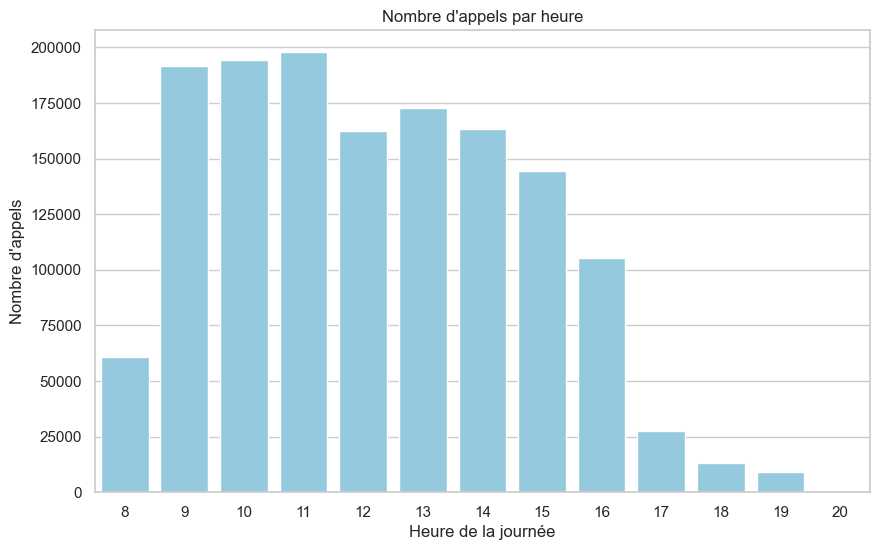

In [9]:
# Nombre d'appels par heure (08h à 20h)
# Groupement par heure (tous jours confondus)
appels_par_heure = donnees_appels.groupby('hour').size().reset_index(name='nombre_appels')

# Affichage en texte
print("Nombre d'appels par heure :")
print(appels_par_heure)

plt.figure(figsize=(10,6))
sns.barplot(data=appels_par_heure, x='hour', y='nombre_appels', color='skyblue')

plt.title("Nombre d'appels par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'appels")

plt.show()

Nombre d'appels par jour de la semaine :
jour_semaine
Monday       341971
Tuesday      306453
Wednesday    285091
Thursday     264541
Friday       244716
Name: count, dtype: int64


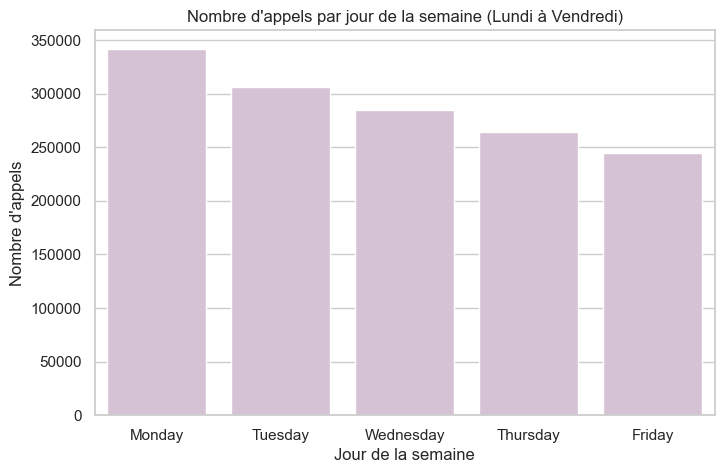

In [ ]:
# Nombre d'appels par jour (lundi au vendredi)
# Création de la colonne 'jour_semaine' avec noms complets des jours en anglais
donnees_appels['jour_semaine'] = donnees_appels['date_received'].dt.day_name()

# Ordre des jours de la semaine à afficher
jour_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Comptage des appels par jour, réindexé dans l’ordre voulu
appels_par_jour = donnees_appels['jour_semaine'].value_counts().reindex(jour_ordre)

# Affichage en texte
print("Nombre d'appels par jour de la semaine :")
print(appels_par_jour)

# Graphique en barres 
plt.figure(figsize=(8,5))
sns.barplot(x=appels_par_jour.index, y=appels_par_jour.values, color='#D8BFD8')

plt.title("Nombre d'appels par jour de la semaine (Lundi à Vendredi)")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre d'appels")
plt.show()

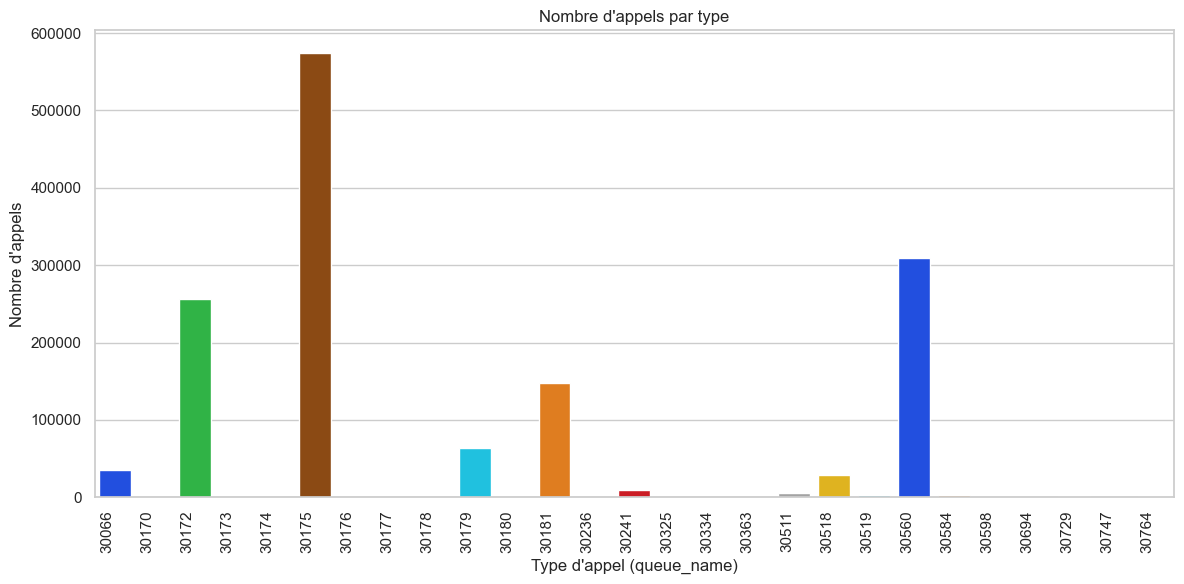

In [11]:
# Comptage des appels par queue_name (file d'attente)
calls_by_type = donnees_appels['queue_name'].value_counts().reset_index()
calls_by_type.columns = ['queue_name', 'nb_calls']

# Taille dynamique du graphique
plt.figure(figsize=(max(12, len(calls_by_type) * 0.3), 6))


sns.barplot(
    x="queue_name",
    y="nb_calls",
    hue="queue_name",
    data=calls_by_type,
    palette="bright",
    legend=False
)

plt.xticks(rotation=90, ha='right')
plt.xlabel("Type d'appel (queue_name)")
plt.ylabel("Nombre d'appels")
plt.title("Nombre d'appels par type")
plt.tight_layout()
plt.show()

Nombre d'appels par type de file d'attente (top 10) :
queue_name
30175    574625
30560    309124
30172    256286
30181    148073
30179     63706
30066     34705
30518     29426
30241     10064
30511      5446
30584      2776
Name: count, dtype: int64


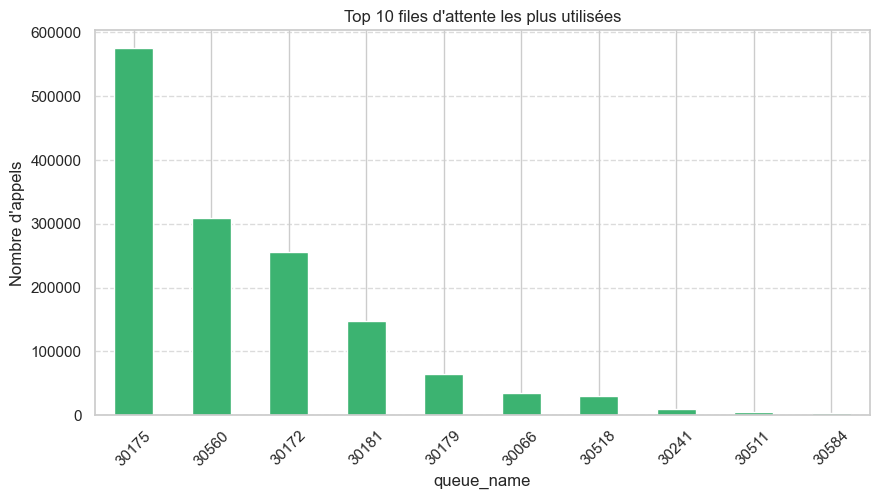

In [12]:
# Comptage des appels par queue_name les plus demandés (file d'attente)
appels_par_queue = donnees_appels['queue_name'].value_counts()

# Affichage des nombres (top 10)
print("Nombre d'appels par type de file d'attente (top 10) :")
print(appels_par_queue.head(10))

# Graphique en barres pour top 10
plt.figure(figsize=(10,5))
appels_par_queue.head(10).plot(kind='bar', color='mediumseagreen')

plt.title("Top 10 files d'attente les plus utilisées")
plt.ylabel("Nombre d'appels")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Top 10 services les moins demandés (queue_name) :
queue_name
30170      1
30178      2
30694      3
30236      9
30334     11
30598     19
30174     25
30325     41
30173     56
30177    108
Name: count, dtype: int64


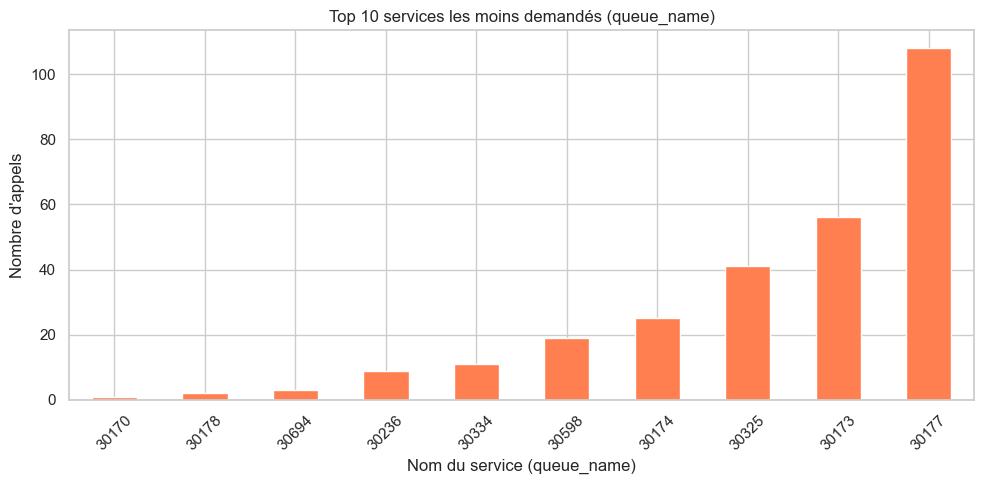

In [14]:
# Comptage des appels par queue_name les moins demandés (file d'attente)
top_services_moins = donnees_appels['queue_name'].value_counts().sort_values().head(10)

# Affichage texte
print("\nTop 10 services les moins demandés (queue_name) :")
print(top_services_moins)

# Affichage graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_services_moins.plot(kind='bar', color='#FF7F50')  
plt.title("Top 10 services les moins demandés (queue_name)")
plt.xlabel("Nom du service (queue_name)")
plt.ylabel("Nombre d'appels")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

agent_id
9503    23821
8373    23334
8861    19858
8076    19587
7823    18957
8384    18311
6991    17912
9109    17559
9514    17491
9515    16968
Name: count, dtype: int64


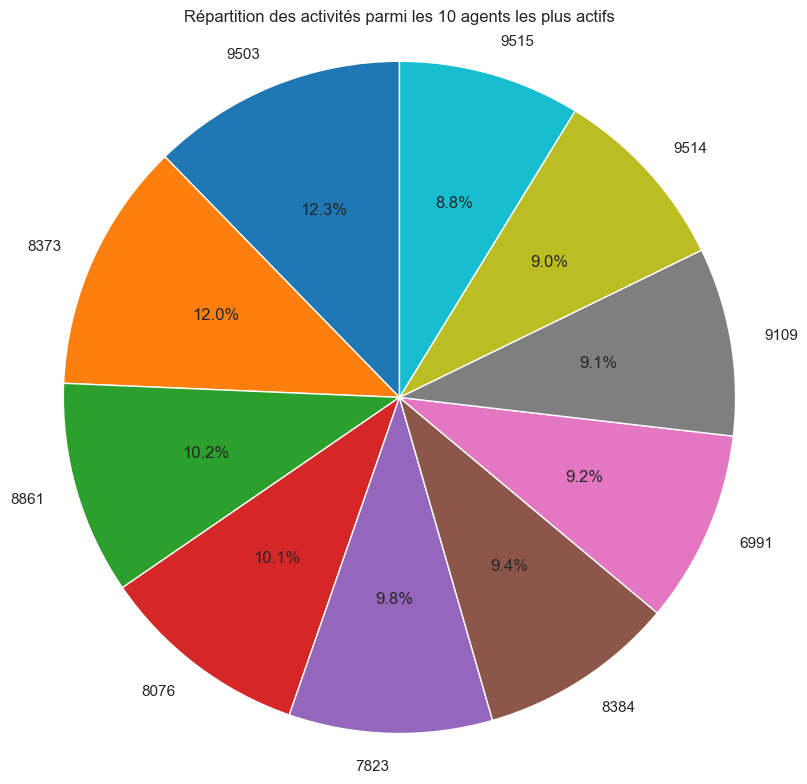

In [15]:
# Top 10 des agents ayant traité plus d'appels
# Comptage des activités par agent
top_agents = donnees_activites['agent_id'].value_counts().head(10)
print(top_agents)

plt.figure(figsize=(8, 8))
plt.pie(
    top_agents, 
    labels=top_agents.index.astype(str),  
    autopct='%1.1f%%',                    
    startangle=90,                        
    colors=plt.cm.tab10.colors           
)

plt.title("Répartition des activités parmi les 10 agents les plus actifs")
plt.axis('equal')  
plt.tight_layout()
plt.show()


Agents les moins actifs (ayant au moins 1 appel) :
agent_id
8562     1
7371     2
4858     5
6942     6
6924     7
6941    25
6939    25
9431    34
7480    36
6958    41
Name: count, dtype: int64


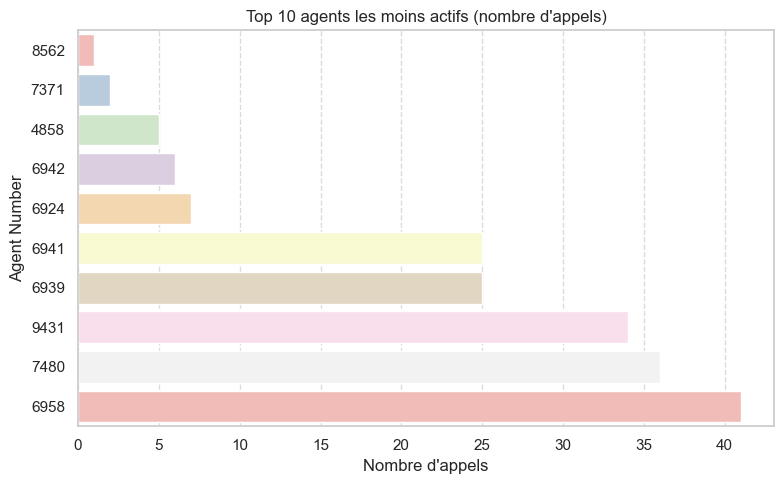

In [16]:
# Comptage des appels par agent (agents les moins actifs)
agents_moins_actifs = donnees_activites['agent_id'].value_counts().sort_values()
agents_moins_actifs = agents_moins_actifs[agents_moins_actifs > 0].head(10)

# Affichage texte
print("\nAgents les moins actifs (ayant au moins 1 appel) :")
print(agents_moins_actifs)

# Barplot horizontal
plt.figure(figsize=(8, 5))
sns.barplot(
    x=agents_moins_actifs.values,
    y=agents_moins_actifs.index.astype(str),
    palette='Pastel1',
    hue=agents_moins_actifs.index.astype(str),
    legend=False
)
plt.title("Top 10 agents les moins actifs (nombre d'appels)")
plt.xlabel("Nombre d'appels")
plt.ylabel("Agent Number")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

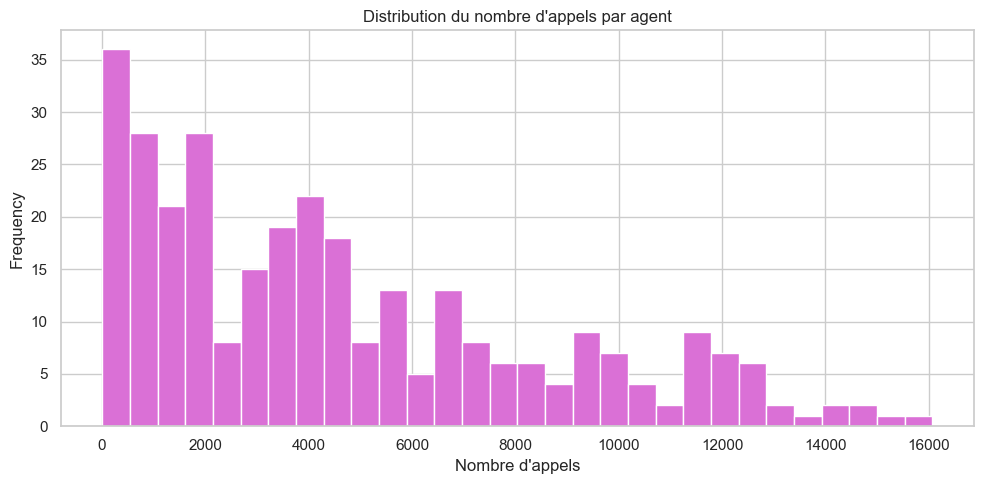

In [17]:
# Distribution du nombre d'appels par agent
plt.figure(figsize=(10, 5))
donnees_appels['agent_number'].value_counts().plot(kind='hist', bins=30, color='orchid')
plt.title("Distribution du nombre d'appels par agent")
plt.xlabel("Nombre d'appels")
plt.grid(True)
plt.tight_layout()
plt.show()

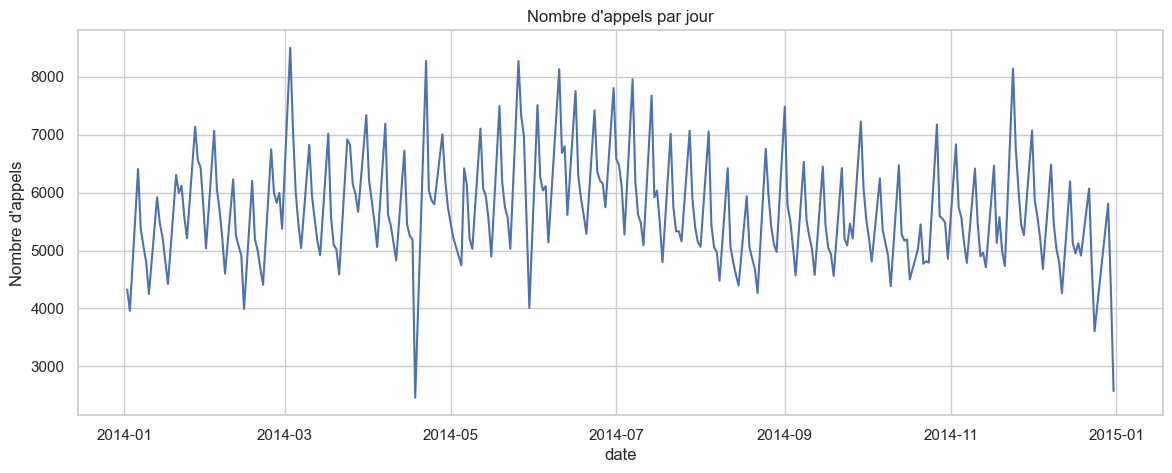

In [18]:
# Analyse du nombre d'appels par jour
# Extraire la date sans l'heure
donnees_appels['date'] = donnees_appels['date_received'].dt.date

# Nombre d'appels par jour
plt.figure(figsize=(14,5))
donnees_appels.groupby('date').size().plot()
plt.title("Nombre d'appels par jour")
plt.ylabel("Nombre d'appels")
plt.grid(True)
plt.show()

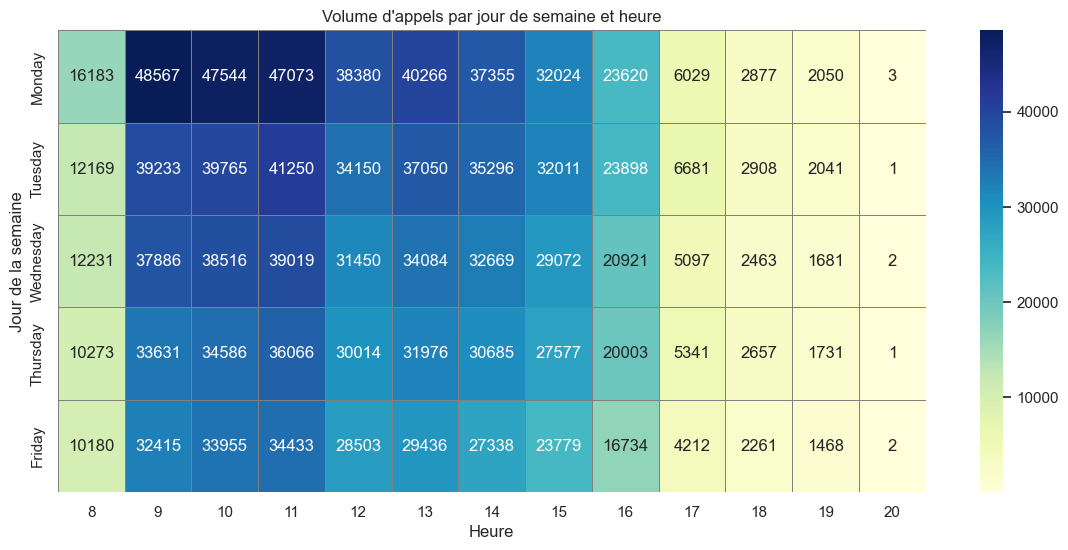

In [19]:
# Visualisation du volume d'appels par heure et jour de la semaine (Heatmap)
jour_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

donnees_appels['date_received'] = pd.to_datetime(donnees_appels['date_received'], errors='coerce')

donnees_appels['heure'] = donnees_appels['date_received'].dt.hour

pivot_jour_heure = donnees_appels.pivot_table(
    index=donnees_appels['date_received'].dt.day_name(),
    columns='heure',
    values='date_received',  
    aggfunc='count'
).reindex(jour_ordre)

plt.figure(figsize=(14,6))
sns.heatmap(pivot_jour_heure, cmap="YlGnBu", linewidths=.5, linecolor='gray', annot=True, fmt='g')

plt.title("Volume d'appels par jour de semaine et heure")
plt.ylabel("Jour de la semaine")
plt.xlabel("Heure")
plt.show()


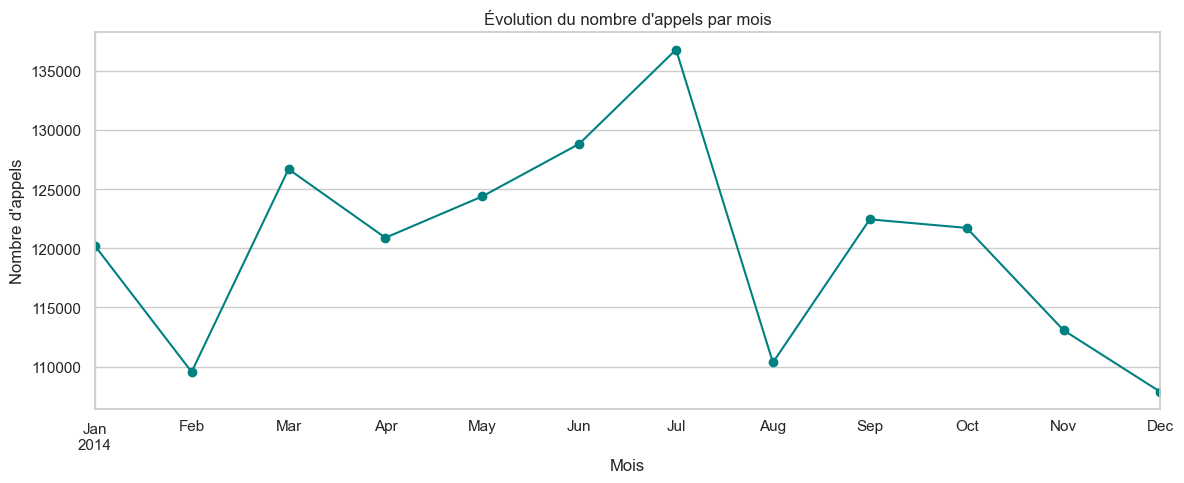

In [20]:
# Évolution mensuelle du volume d'appels reçus
donnees_appels['month'] = donnees_appels['date_received'].dt.to_period("M")

# Grouper par mois et compter le nombre d'appels
calls_by_month = donnees_appels.groupby("month").size()

plt.figure(figsize=(12, 5))
calls_by_month.plot(marker="o", linestyle='-', color='teal')

plt.title("Évolution du nombre d'appels par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'appels")
plt.grid(True)
plt.tight_layout()
plt.show()


Top 10 jours avec le plus d'appels :
date
2014-03-03    8499
2014-04-22    8273
2014-05-26    8269
2014-11-24    8139
2014-06-10    8129
2014-07-07    7957
2014-06-30    7803
2014-06-16    7751
2014-07-14    7673
2014-06-02    7508
Name: count, dtype: int64


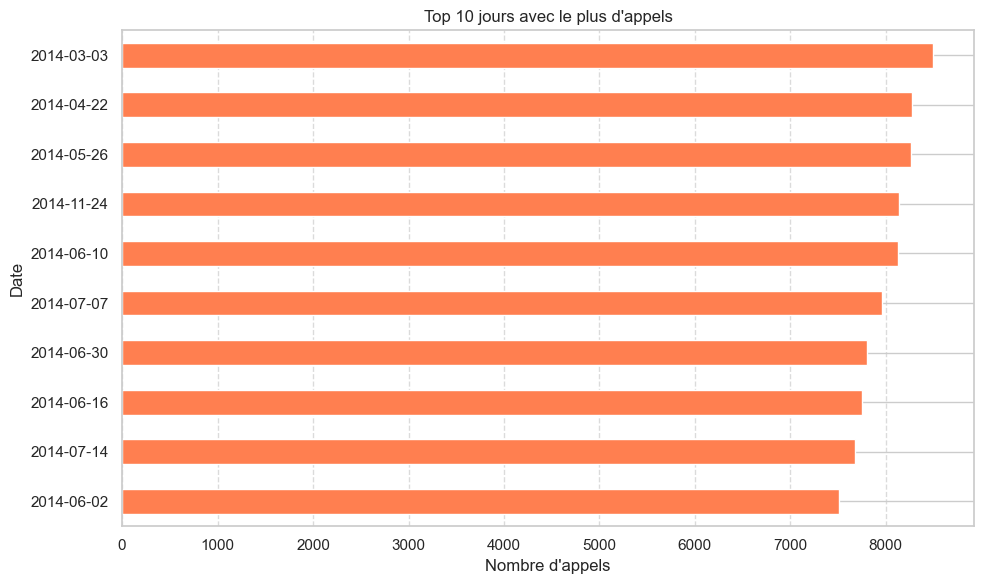

In [ ]:
# Top 10 des journées les plus chargées en appels

top10_jours = donnees_appels['date'].value_counts().sort_values(ascending=False).head(10)

# Affichage en texte
print("\nTop 10 jours avec le plus d'appels :")
print(top10_jours)

# Affichage en graphique
plt.figure(figsize=(10,6))
top10_jours.sort_values().plot(kind='barh', color='coral')  

plt.title("Top 10 jours avec le plus d'appels")
plt.xlabel("Nombre d'appels")
plt.ylabel("Date")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

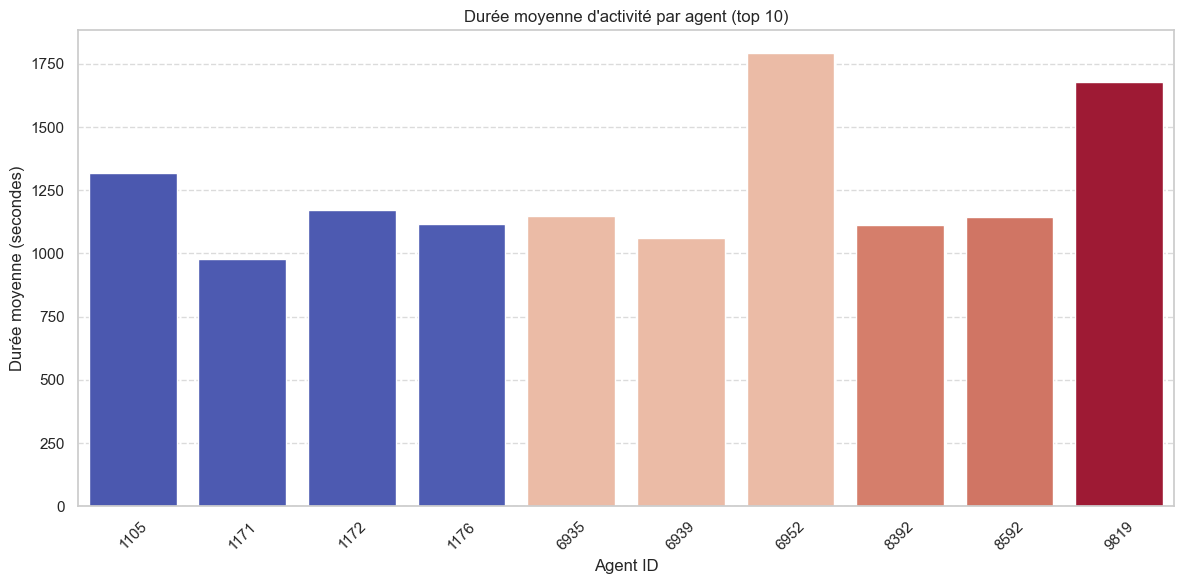

In [22]:
# Calcul durée moyenne par agent (top 10)
duree_moyenne = donnees_activites.groupby('agent_id')['duration'].mean().sort_values(ascending=False).head(10)

# Préparation DataFrame
df_duree_moyenne = duree_moyenne.reset_index()
df_duree_moyenne.columns = ['agent_id', 'duree_moyenne_sec']

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_duree_moyenne, 
    x='agent_id', 
    y='duree_moyenne_sec', 
    hue='agent_id',       
    palette='coolwarm',
)

plt.title("Durée moyenne d'activité par agent (top 10)")
plt.xlabel("Agent ID")
plt.ylabel("Durée moyenne (secondes)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([],[], frameon=False)  

plt.show()


Temps moyen d'attente par heure :
hour
8     16.826578
9     27.522219
10    31.101726
11    33.751037
12    45.994788
13    48.924762
14    40.303643
15    51.911597
16    48.486271
17    69.455592
18    41.389488
19    42.785308
20    12.333333
Name: waiting_time, dtype: float64


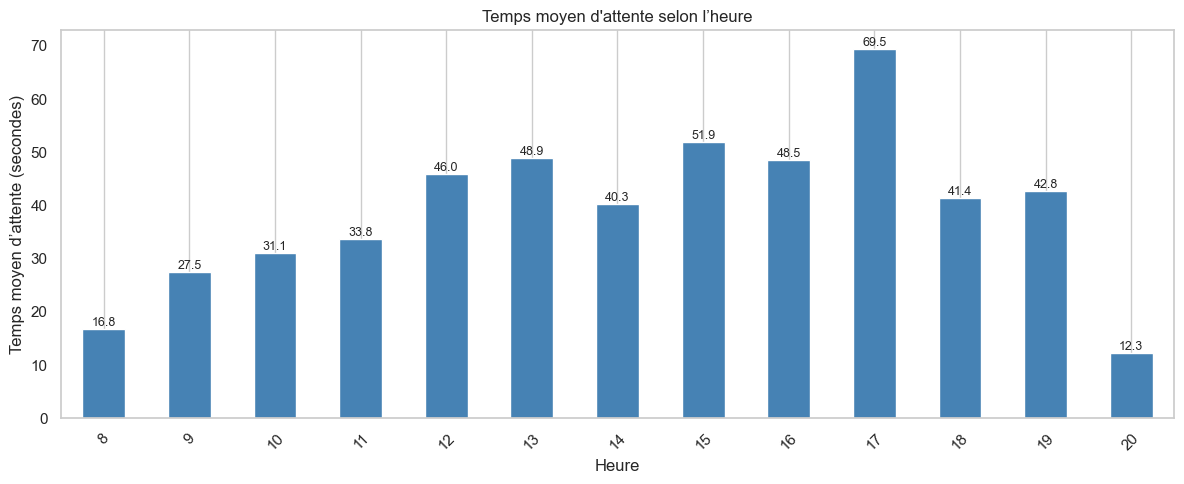

In [23]:
# Temps moyen d'attente par heure
print("\nTemps moyen d'attente par heure :")
moyenne_attente_par_heure = donnees_appels.groupby('hour')['waiting_time'].mean()
print(moyenne_attente_par_heure)

plt.figure(figsize=(12,5))
ax = moyenne_attente_par_heure.plot(kind='bar', color='#4682B4')  

plt.title("Temps moyen d'attente selon l’heure")
plt.ylabel("Temps moyen d’attente (secondes)")
plt.xlabel("Heure")
plt.xticks(rotation=45)
plt.grid(axis='y')

for p in ax.patches:
    hauteur = p.get_height()
    ax.annotate(f'{hauteur:.1f}', (p.get_x() + p.get_width() / 2, hauteur),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

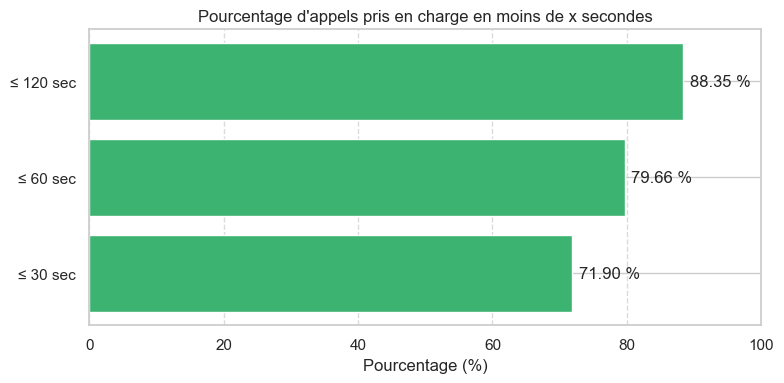

In [24]:
# Pourcentage d'appels pris en charge en moins de 30 secondes, 1 min, 2 min

# Seuils en secondes
seuils = [30, 60, 120]
pourcentages = [(donnees_appels['waiting_time'] <= s).mean() * 100 for s in seuils]

# Graphique barres horizontales
plt.figure(figsize=(8,4))
plt.barh([f"≤ {s} sec" for s in seuils], pourcentages, color='mediumseagreen')
plt.xlabel("Pourcentage (%)")
plt.title("Pourcentage d'appels pris en charge en moins de x secondes")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, pct in enumerate(pourcentages):
    plt.text(pct + 1, i, f"{pct:.2f} %", va='center')

plt.tight_layout()
plt.show()

In [25]:
# Écart-type des temps d’attente par file d'attente (queue_name)
print("\nÉcart-type des temps d’attente par file d'attente :")
ecart_type_attente = donnees_appels.groupby('queue_name')['waiting_time'].std().sort_values(ascending=False).head(10)
print(ecart_type_attente)


Écart-type des temps d’attente par file d'attente :
queue_name
30173    93.010284
30511    88.804190
30172    84.775453
30181    84.265338
30560    82.526007
30518    79.849675
30363    77.753611
30175    76.178405
30179    75.277915
30066    73.507405
Name: waiting_time, dtype: float64


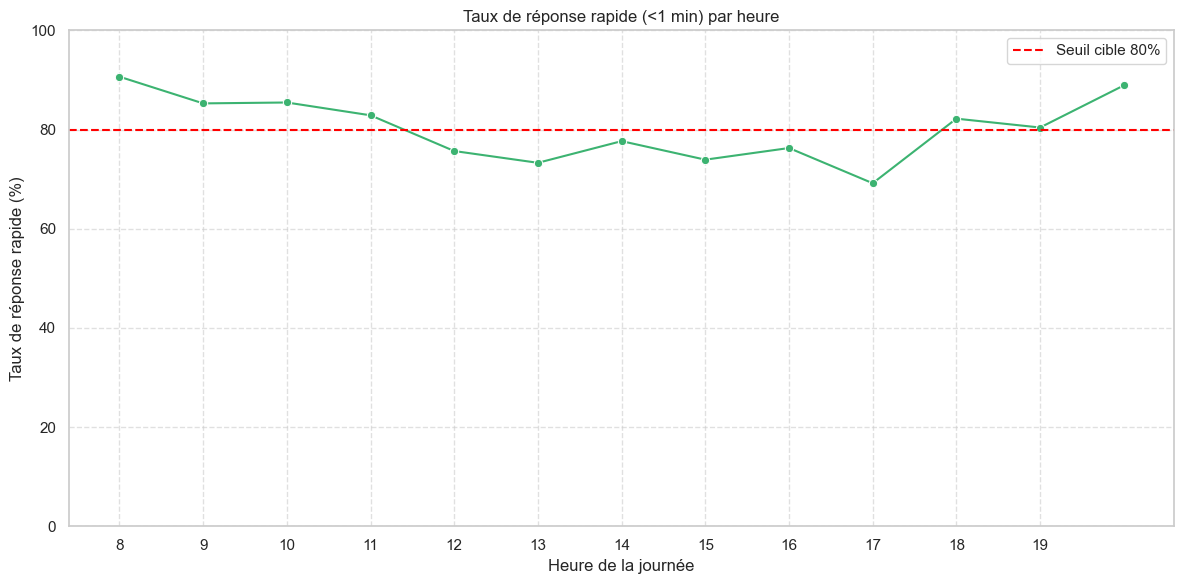

In [26]:
# Taux de réponses rapides (< 1 minute) des appels par heure de la journée
# Création d'une colonne booléenne : 1 si attente <= 60 sec, sinon 0
donnees_appels['reponse_rapide'] = (donnees_appels['waiting_time'] <= 60).astype(int)

# Groupby heure : total appels et total réponses rapides
grouped = donnees_appels.groupby('heure').agg(
    total_appels=('waiting_time', 'count'),
    reponses_rapides=('reponse_rapide', 'sum')
)

# Taux en %
grouped['taux_reponse_rapide'] = (grouped['reponses_rapides'] / grouped['total_appels']) * 100

# Affichage graphique
plt.figure(figsize=(12,6))
sns.lineplot(data=grouped, x=grouped.index, y='taux_reponse_rapide', marker='o', color='mediumseagreen')
plt.axhline(80, color='red', linestyle='--', label='Seuil cible 80%')
plt.title("Taux de réponse rapide (<1 min) par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Taux de réponse rapide (%)")
plt.xticks(range(8, 20))
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


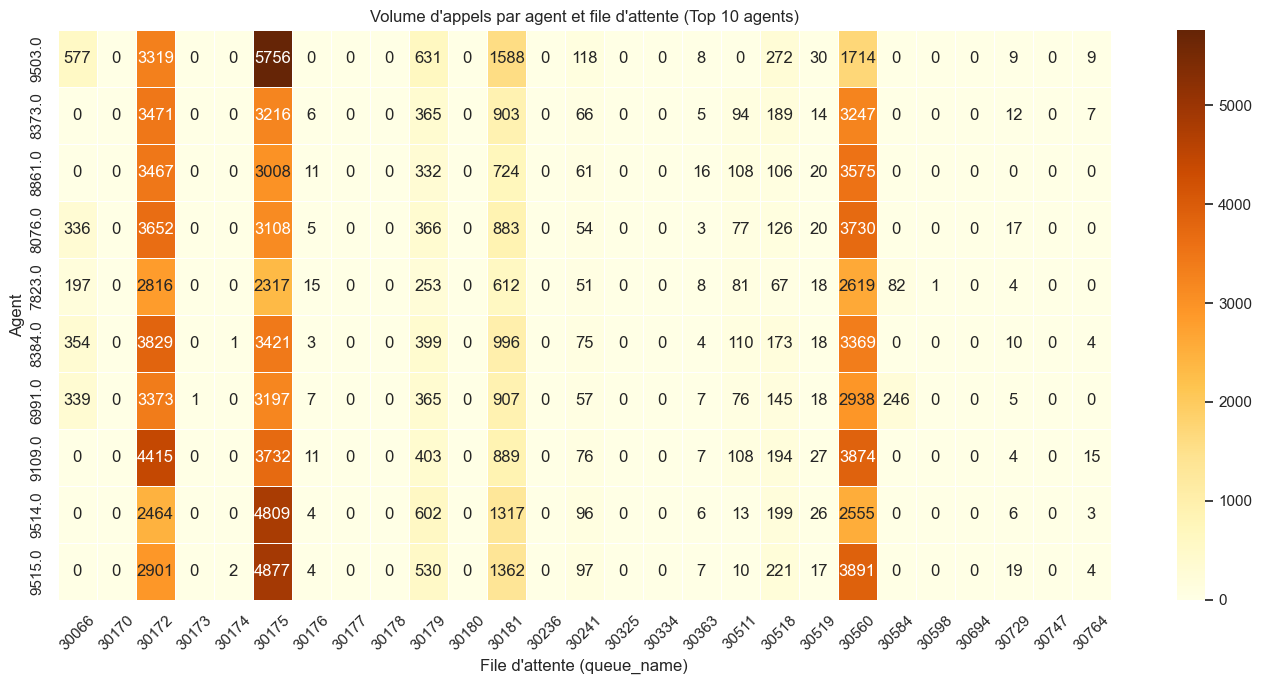

In [27]:
# Répartition du volume d'appels par agent et file d'attente (Top 10 agents)
# Calcul de la matrice agent x queue_name
combinaison = donnees_appels.groupby(['agent_number', 'queue_name']).size().unstack(fill_value=0)

# Top 10 agents les plus actifs
top_agents = donnees_activites['agent_id'].value_counts().head(10).index
combinaison_top = combinaison.loc[top_agents]

plt.figure(figsize=(14,7))
sns.heatmap(combinaison_top, cmap="YlOrBr", linewidths=0.5, annot=True, fmt="d")

plt.title("Volume d'appels par agent et file d'attente (Top 10 agents)")
plt.xlabel("File d'attente (queue_name)")
plt.ylabel("Agent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

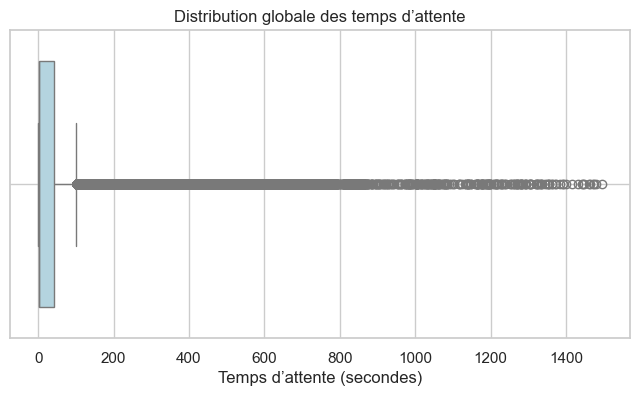

In [28]:
# Analyse de la distribution des temps d’attente des appels
plt.figure(figsize=(8,4))
sns.boxplot(data=donnees_appels, x='waiting_time', color='lightblue')
plt.title("Distribution globale des temps d’attente")
plt.xlabel("Temps d’attente (secondes)")
plt.grid(True)
plt.show()